In [31]:
# Standard library imports
import os
import sys
import time
from itertools import combinations

# Numerical and Scientific Libraries
import numpy as np
from scipy import signal, linalg
from scipy.interpolate import splrep, BSpline
from scipy.stats import loguniform
from scipy.ndimage import convolve

# Astropy Modules
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy import constants, cosmology, units as u

# Photutils Modules
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground, SExtractorBackground

# Machine Learning and Gaussian Processes
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
import GPy
import emcee

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML

# LAL Modules
from lal import gpstime

# NFFT for Fourier Transforms
import nfft

# Astropy Cosmology
from astropy.cosmology import Planck18, FlatLambdaCDM

# Plotting configuration
mpl.rcParams.update({
    'text.usetex': True,
    'xtick.major.size': 8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.3,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.3,
    'patch.linewidth': 1.3,
    'axes.linewidth': 2
})

# Set environment variables
os.environ["OMP_NUM_THREADS"] = "1"

# Display settings for Jupyter Notebooks
display(HTML("<style>.container { width:100% !important; }</style>"))

# Add custom module paths
sys.path.insert(1, '../../milestone2/bispec_phase/scripts/notebooks/')


In [32]:
data_path = '/media/himanshu/MyHDD/data_galaxy_evolution/data/'  # path to HST-JWST fits images
# loading EELGS and control galaxy samples
catalog = data_path + 'sample_details/'
eelgs = catalog + 'eelgs_28aug2024.dat'
control = catalog + 'control_28aug2024.dat'

In [33]:
c0 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits')
c1 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s-deephst_clear-prism_line-fluxes_v1.0_catalog.fits')
c2 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s-deephst_gratings_line-fluxes_v1.0_catalog.fits')
c3 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s_gratings-line-fluxes_v1.1_catalog.fits')
c4 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s_prism-line-fluxes_v1.1_catalog.fits')

In [34]:
# extracting sample data : id, ra, dec, photo_z, spec_z
use_control = False
if use_control == True:
    data_columns = np.loadtxt(control, dtype='str', delimiter=',')[0]
    sample_data  = np.loadtxt(control, delimiter=',', skiprows=1)
else:
    
    data_columns = np.loadtxt(eelgs, dtype='str', delimiter=',')[0]
    sample_data  = np.loadtxt(eelgs, delimiter=',', skiprows=1)
    
new_dtype = [(name, float) for name in data_columns]
sample_data = np.array([tuple(row) for row in sample_data], dtype=new_dtype)

In [35]:
sample_data.shape # total sample

(33,)

In [36]:
# data selection for high redshift
ind = np.where(sample_data['zspec'] > 3.08)
#if use_control == True:
#    ra, dec, zspec = sample_data['RA'][ind], sample_data['dec'][ind], sample_data['zspec'][ind]
#else:
#    ra, dec, zspec = sample_data['RA'.lower()][ind], sample_data['dec'][ind], sample_data['zspec'][ind]
#    
sample_data = sample_data[ind]

In [37]:
offset = 0.3*u.arcsecond
offset = offset.to(u.deg)

In [38]:
sample_data['dec'] = sample_data['dec'] - offset.value

In [39]:
#peak_cutout_filt0_arr = [item for i, item in enumerate(peak_cutout_filt0_arr) if i not in good_segmentation_index]
#peak_cutout_wts0_arr  = [item for i, item in enumerate(peak_cutout_wts0_arr ) if i not in good_segmentation_index]
#peak_cutout_filt1_arr = [item for i, item in enumerate(peak_cutout_filt1_arr) if i not in good_segmentation_index]
#peak_cutout_wts1_arr  = [item for i, item in enumerate(peak_cutout_wts1_arr ) if i not in good_segmentation_index]
#err_ind               = [item for i, item in enumerate(err_ind) if i not in good_segmentation_index]
#good_ind              = [item for i, item in enumerate(good_ind) if i not in good_segmentation_index]


In [40]:
good_segmentation_index = np.array([1, 2, 4, 5, 6, 7, 10,11,13,14,15,16,17,19,21, 
                                    22,24,25,27,28,29,30,31,34,35,36,37,39,40,41,43,44,45,46,47,48,
                                   49,50,54,55,56,57,58,59,64,65,66,68,70,71,72,73,76,
                                   77,78,79,80,81,82,83]) -1

In [41]:
#sample_data = sample_data[good_ind]
#sample_data = np.delete(sample_data, good_segmentation_index)

In [42]:
# loading fits files for two filters, e.g. first non-ionizing filter (base filter), second ionizing filter

def load_fits(filt0, filt1):
    '''
    filt0: name of the filter
    
    filt1: name of the filter
    
    returns: fits filters and weights
    '''
    fitsfile0     = data_path  + 'hlsp_fresco_hst_acs-wfc_goods-s_%s_v1.0_sci.fits'%filt0
    fitsfile_wts0 = data_path  + 'hlsp_fresco_hst_acs-wfc_goods-s_%s_v1.0_wht.fits'%filt0
    fitsfile1     = data_path  + 'hlsp_fresco_hst_wfc3-uvis_goods-s_%s_v1.0_sci.fits'%filt1
    fitsfile_wts1 = data_path  + 'hlsp_fresco_hst_wfc3-uvis_goods-s_%s_v1.0_wht.fits'%filt1
    
    return fitsfile0, fitsfile_wts0, fitsfile1, fitsfile_wts1

In [43]:
filt0='f814w' # non-ionizing filter
filt1='f336w' # ionizing filter
fitsfile0, fitsfile_wts0, fitsfile1, fitsfile_wts1 = load_fits(filt0='f814w', filt1='f336w')

In [44]:
#loading the filters
f0  = fits.open(fitsfile0)
fw0 = fits.open(fitsfile_wts0)

f1  = fits.open(fitsfile1)
fw1 = fits.open(fitsfile_wts1)

flux_units = f0[0].header['bunit']
# Check if FILTER2 or FILTER is present in the header
if 'FILTER2' in f0[0].header or 'FILTER' in f[0].header:
    # Access the filters, defaulting to empty string if not present
    filter2 = f0[0].header.get('FILTER2', '')
    filter1 = f0[0].header.get('FILTER', '')

    # Determine the filter that starts with 'F'
    filt = filter2 if filter2.startswith('F') else (filter1 if filter1.startswith('F') else None)
    
    if filt:
        print(f"Selected Filter: {filt}")
    else:
        print("No filter starts with 'F'.")
else:
    print("Neither FILTER2 nor FILTER is present in the header.")


Selected Filter: F814W


In [45]:
wcs = WCS(f0[0]) #wcs of the filter

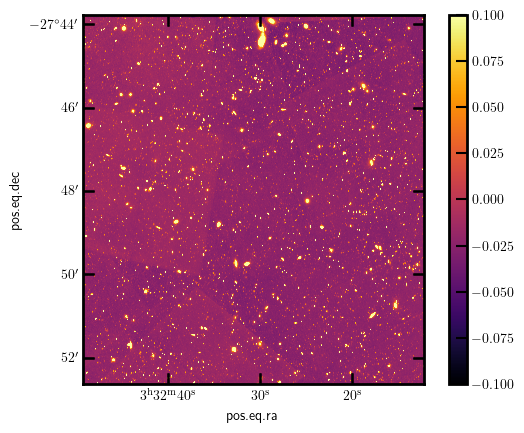

In [46]:
#@example image
fig = plt.subplot(projection=wcs)
plt.imshow(f0[0].data, vmax=0.1, vmin=-0.1, origin='lower', cmap='inferno')
plt.colorbar()
plt.show() #filter 1

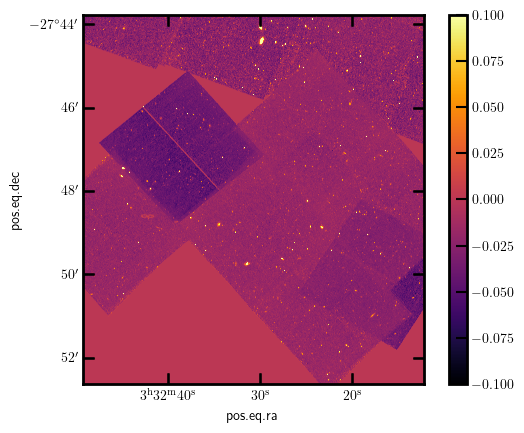

In [47]:
fig = plt.subplot(projection=wcs)
plt.imshow(f1[0].data, vmax=0.1, vmin=-0.1, origin='lower', cmap='inferno')
plt.colorbar()
plt.show() #filter 2

In [48]:
# creating cutouts of the of the galaxies in the data_sample

In [49]:
def cutout_centered_on_local_peak_with_tolerance(
    image_data_filt0, wts_data_filt0, image_data_filt1, wts_data_filt1, position, size, tolerance_arcsec):
    """
    Create a cutout image around a specified RA/Dec, find the peak flux within a tolerance 
    angular size, recenter a cutout around the peak, and optionally calculate RMS noise.

    Parameters:
    - image_data_filt0, wts_data_filt0: 2D arrays for the first dataset (flux and weights).
    - image_data_filt1, wts_data_filt1: 2D arrays for the second dataset (flux and weights).
    - position (tuple): RA and Dec of the centre to look around, in degrees.
    - size (int or tuple): Cutout size, in pixels (ny, nx).
    - tolerance_arcsec (float): Angular size tolerance (in arcseconds) to find the peak around the centre.

    Returns:
    - peak_cutout_filt0: Cutout of image_data_filt0 centred on the peak flux.
    - peak_cutout_wts0: Cutout of wts_data_filt0 centred on the peak flux.
    - peak_cutout_filt1: Cutout of image_data_filt1 centred on the peak flux.
    - peak_cutout_wts1: Cutout of wts_data_filt1 centred on the peak flux.
    """
    # Step 1: Convert RA/Dec to pixel coordinates for the initial centre
    coord = SkyCoord(ra=position[0] * u.deg, dec=position[1] * u.deg, frame='icrs')
    wcs = WCS(image_data_filt0[0])
    initial_center_pix = wcs.world_to_pixel(coord)

    # Step 2: Create an initial cutout around the specified RA/Dec position
    initial_cutout = Cutout2D(image_data_filt0[0].data, initial_center_pix, size, wcs=wcs)

    # Step 3: Convert the tolerance from arcseconds to pixels
    pixel_scale = np.abs(wcs.pixel_scale_matrix[1, 1]) * 3600  # arcseconds per pixel
    tolerance_pixels = tolerance_arcsec / pixel_scale

    # Step 4: Create a circular mask within the tolerance radius
    ny, nx = initial_cutout.data.shape
    y, x = np.ogrid[:ny, :nx]
    center_y, center_x = ny // 2, nx // 2
    distance_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    mask = distance_from_center <= tolerance_pixels

    # Step 5: Find the peak flux within the masked region
    masked_data = np.where(mask, initial_cutout.data, -np.inf)
    peak_position_cutout = np.unravel_index(np.argmax(masked_data), masked_data.shape)

    # Debug: Verify peak position in the cutout
    print(f"Peak position in cutout: {peak_position_cutout}")

    # Calculate global pixel coordinates of the peak position
    peak_position_global = (
        initial_cutout.origin_original[0] + peak_position_cutout[1],
        initial_cutout.origin_original[1] + peak_position_cutout[0],
    )

    # Step 6: Create new cutouts centred on the peak position
    peak_cutout_filt0 = Cutout2D(image_data_filt0[0].data, peak_position_global, size, wcs=wcs)
    peak_cutout_wts0 = Cutout2D(wts_data_filt0[0].data, peak_position_global, size, wcs=wcs)
    peak_cutout_filt1 = Cutout2D(image_data_filt1[0].data, peak_position_global, size, wcs=wcs)
    peak_cutout_wts1 = Cutout2D(wts_data_filt1[0].data, peak_position_global, size, wcs=wcs)

    return peak_cutout_filt0, peak_cutout_wts0, peak_cutout_filt1, peak_cutout_wts1

def cutout_centered_on_local_peak_with_background_rms(
    image_data_filt0, wts_data_filt0, image_data_filt1, wts_data_filt1,
    position, size, calculate_rms=False, annulus_distance_arcsec=40, annulus_width_arcsec=20):
    """
    Create cutouts of input data centered on the peak flux within a specified region
    and optionally calculate the RMS noise in the background annulus.

    Parameters:
    - image_data_filt0, wts_data_filt0, image_data_filt1, wts_data_filt1: 
      2D arrays of flux and weight data for two datasets.
    - position (tuple): RA and Dec (degrees) around which to center the cutout.
    - size (int or tuple): Cutout size in pixels (ny, nx).
    - calculate_rms (bool): Whether to calculate the background RMS.
    - annulus_distance_arcsec (float): Distance (arcsec) to the inner edge of the annulus.
    - annulus_width_arcsec (float): Width (arcsec) of the annulus.

    Returns:
    - peak_cutout_filt0, peak_cutout_wts0, peak_cutout_filt1, peak_cutout_wts1: 
      Cutouts centered on the peak flux.
    - background_rms (float, optional): RMS noise from the background annulus (if calculate_rms=True).
    """
    # Convert RA/Dec to pixel coordinates for the initial center
    coord = SkyCoord(ra=position[0] * u.deg, dec=position[1] * u.deg, frame='icrs')
    wcs = WCS(image_data_filt0[0])
    initial_center_pix = wcs.world_to_pixel(coord)
    
    # Step 1: Create an initial cutout around the specified position
    initial_cutout = Cutout2D(image_data_filt0[0].data, initial_center_pix, size, wcs=wcs)
    
    # Step 2: Find the peak flux within the cutout
    peak_position_cutout = np.unravel_index(np.argmax(initial_cutout.data), initial_cutout.data.shape)
    peak_position_global = (initial_cutout.origin_original[0] + peak_position_cutout[1],
                            initial_cutout.origin_original[1] + peak_position_cutout[0])
    
    # Step 3: Create cutouts centered on the peak position
    peak_cutout_filt0 = Cutout2D(image_data_filt0[0].data, peak_position_global, size, wcs=wcs)
    peak_cutout_wts0  = Cutout2D(wts_data_filt0[0].data, peak_position_global, size, wcs=wcs)
    peak_cutout_filt1 = Cutout2D(image_data_filt1[0].data, peak_position_global, size, wcs=wcs)
    peak_cutout_wts1  = Cutout2D(wts_data_filt1[0].data, peak_position_global, size, wcs=wcs)
    
    # Step 4: Optional background RMS calculation
    if calculate_rms:
        pixel_scale = np.abs(wcs.pixel_scale_matrix[1, 1]) * 3600  # Arcsec per pixel
        annulus_inner_radius = annulus_distance_arcsec / pixel_scale
        annulus_outer_radius = (annulus_distance_arcsec + annulus_width_arcsec) / pixel_scale
        
        # Define background annulus mask
        ny, nx = peak_cutout_filt0.data.shape
        y, x = np.ogrid[:ny, :nx]
        center_y, center_x = ny // 2, nx // 2
        distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        background_mask = (distance_from_center >= annulus_inner_radius) & (distance_from_center <= annulus_outer_radius)
        
        # Calculate RMS
        background_rms = np.std(peak_cutout_filt0.data[background_mask])
        return peak_cutout_filt0, peak_cutout_wts0, peak_cutout_filt1, peak_cutout_wts1, background_rms
    
    return peak_cutout_filt0, peak_cutout_wts0, peak_cutout_filt1, peak_cutout_wts1

def fill_masked_with_noise(image, mask):
    """
    Fills masked regions of an image with noise matching the unmasked regions.

    Parameters:
    - image (numpy.ndarray): The input image.
    - mask (numpy.ndarray): A boolean mask where True indicates masked pixels.

    Returns:
    - numpy.ndarray: The image with masked regions filled with noise.
    """
    if image.shape != mask.shape:
        raise ValueError("Image and mask must have the same shape.")

    # Create a masked array
    masked_image = np.ma.masked_array(image, mask=mask)
    
    # Calculate noise level (standard deviation of unmasked pixels)
    noise_level = np.std(masked_image.compressed())
    
    # Generate noise for masked pixels
    random_noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
    
    # Create a copy of the original image to modify
    noisy_image = image.copy()
    
    # Fill the masked regions with generated noise
    noisy_image[mask] = random_noise[mask]
    
    return noisy_image

def apply_closest_mask(data, segment):
    """
    Applies the closest mask to the centre of the input image and merges all other masks.

    Parameters:
        data (numpy.ndarray): The 2D image array.
        segment (photutils.segmentation.SegmentationImage): The segmentation object.

    Returns:
        masked_image (numpy.ndarray): The image with the closest mask applied.
        closest_mask (numpy.ndarray): The closest mask applied to the image.
        merged_other_masks (numpy.ndarray): A single mask combining all other segments.
    """
    # Determine the centre pixel of the image
    centre_y, centre_x = np.array(data.shape) // 2
    
    # Get the number of segment labels
    nlabels = segment.nlabels
    print(f"Number of segments: {nlabels}")
    if nlabels != 1:
        
        segment_masks = []
        mask_coords = []
        dist_mask = []

        for label in range(1, nlabels + 1):
            # Create a mask for the current label
            current_mask = segment.data == label
            segment_masks.append(current_mask)

            # Get pixel coordinates of the current mask
            mask_coords.append(np.array(np.where(current_mask)).T)

            # Compute the distance from the mask to the centre pixel
            distances = np.sqrt((mask_coords[label - 1][:, 1] - centre_x)**2 +
                                (mask_coords[label - 1][:, 0] - centre_y)**2)
            dist_mask.append(np.min(distances))  # Minimum distance for the current mask

        # Find the closest mask
        dist_mask = np.array(dist_mask)
        closest_mask_ind = int(np.argmin(dist_mask))  # Index of the closest mask
        closest_mask = segment_masks[closest_mask_ind]

        # Merge all other masks
        merged_other_masks = np.logical_or.reduce([mask for idx, mask in enumerate(segment_masks) if idx != closest_mask_ind])

        # Apply the closest mask to the image
        masked_image = np.where(closest_mask, data, np.nan)  # Replace masked regions with NaN
    
    else:
        closest_mask = segment.data == nlabels
        merged_other_masks = np.zeros(shape=data.shape, dtype=bool)
        masked_image = np.where(closest_mask, data, np.nan)
    return masked_image, closest_mask, merged_other_masks

def get_cutout_data_array(sample_data, use_control=False):
    """
    Process a list of RA/Dec positions and generate cutouts for each position.
    
    Parameters:
    - sample_data (structured array or DataFrame): Input data with RA/Dec values.
    - use_control (bool): If True, use column names 'RA' and 'dec'; otherwise, use 'ra' and 'dec'.
    
    Returns:
    - peak_cutout_filt0_arr (list): Cutouts of filtered image data (filter 0).
    - peak_cutout_wts0_arr (list): Cutouts of weights data (filter 0).
    - peak_cutout_filt1_arr (list): Cutouts of filtered image data (filter 1).
    - peak_cutout_wts1_arr (list): Cutouts of weights data (filter 1).
    - err_ind (numpy array): Indices of failed cutouts.
    """
    # Initialize result arrays
    peak_cutout_filt0_arr, peak_cutout_wts0_arr = [], []
    peak_cutout_filt1_arr, peak_cutout_wts1_arr = [], []
    err_ind = []

    # Select the column names for RA and Dec based on `use_control`
    ra_col = 'RA' if use_control else 'ra'
    dec_col = 'dec'

    for i in range(len(sample_data)):
        try:
            # Extract RA/Dec for the current index
            position = [sample_data[ra_col][i], sample_data[dec_col][i]]
            
            # Generate cutouts
            peak_cutout_filt0, peak_cutout_wts0, peak_cutout_filt1, peak_cutout_wts1 = \
                cutout_centered_on_local_peak_with_background_rms(
                    image_data_filt0=f0,
                    wts_data_filt0=fw0,
                    image_data_filt1=f1,
                    wts_data_filt1=fw1,
                    position=position,
                    size=5 * u.arcsecond
                )
            
            # Append results
            peak_cutout_filt0_arr.append(peak_cutout_filt0)
            peak_cutout_wts0_arr.append(peak_cutout_wts0)
            peak_cutout_filt1_arr.append(peak_cutout_filt1)
            peak_cutout_wts1_arr.append(peak_cutout_wts1)
        
        except Exception as e:
            print(f"Error at index {i}: {e}")
            err_ind.append(i)
    
    # Convert error indices to numpy array
    err_ind = np.array(err_ind)
    
    return peak_cutout_filt0_arr, peak_cutout_wts0_arr, peak_cutout_filt1_arr, peak_cutout_wts1_arr, err_ind

def get_cleaned_data(arr, arr_ind):
    arr_dummy = []
    for i in range(len(arr_ind)):
        arr_dummy.append(arr[arr_ind[i]])
    
    return np.array(arr_dummy)

In [50]:
def get_cutout_data_array_v2(sample_data, size, use_control=False):
    """
    Generate cutouts centered on the local peak within a specified tolerance around RA/Dec positions.
    
    Parameters:
    - sample_data (structured array or DataFrame): Input data with RA/Dec values.
    - use_control (bool): If True, use column names 'RA' and 'dec'; otherwise, use 'ra' and 'dec'.
    
    Returns:
    - peak_cutout_filt0_arr (list): Cutouts of filtered image data (filter 0).
    - peak_cutout_wts0_arr (list): Cutouts of weights data (filter 0).
    - peak_cutout_filt1_arr (list): Cutouts of filtered image data (filter 1).
    - peak_cutout_wts1_arr (list): Cutouts of weights data (filter 1).
    - err_ind (numpy array): Indices of failed cutouts.
    """
    # Initialise result lists
    peak_cutout_filt0_arr, peak_cutout_wts0_arr = [], []
    peak_cutout_filt1_arr, peak_cutout_wts1_arr = [], []
    err_ind = []

    # Column selection based on `use_control`
    ra_col = 'ra' if use_control else 'ra'
    dec_col = 'dec'

    # Iterate through each entry in sample_data
    for i in range(len(sample_data)):
        try:
            # Extract RA/Dec for the current index
            position = [sample_data[ra_col][i], sample_data[dec_col][i]]
            
            # Call the cutout function with tolerance
            peak_cutout_filt0, peak_cutout_wts0, peak_cutout_filt1, peak_cutout_wts1 = \
                cutout_centered_on_local_peak_with_tolerance(
                    image_data_filt0=f0,
                    wts_data_filt0=fw0,
                    image_data_filt1=f1,
                    wts_data_filt1=fw1,
                    position=position,
                    size=size * u.arcsecond,
                    tolerance_arcsec=0.1
                )
            
            # Append the resulting cutouts
            peak_cutout_filt0_arr.append(peak_cutout_filt0)
            peak_cutout_wts0_arr.append(peak_cutout_wts0)
            peak_cutout_filt1_arr.append(peak_cutout_filt1)
            peak_cutout_wts1_arr.append(peak_cutout_wts1)
        
        except Exception as e:
            # Print specific error details and log the index
            print(f"Error at index {i}: {e}")
            err_ind.append(i)
    
    # Convert error indices to numpy array for consistency
    err_ind = np.array(err_ind)
    
    return peak_cutout_filt0_arr, peak_cutout_wts0_arr, peak_cutout_filt1_arr, peak_cutout_wts1_arr, err_ind


In [51]:
peak_cutout_filt0_arr, peak_cutout_wts0_arr, peak_cutout_filt1_arr, peak_cutout_wts1_arr, err_ind = get_cutout_data_array_v2(sample_data=sample_data, size=5) # cutout to full list and arrays

Peak position in cutout: (62, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (63, 60)
Peak position in cutout: (64, 63)
Peak position in cutout: (62, 60)
Peak position in cutout: (62, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (62, 60)
Peak position in cutout: (63, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (63, 60)
Peak position in cutout: (62, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (61, 60)
Peak position in cutout: (63, 60)
Peak position in cutout: (63, 60)
Peak position in cutout: (61, 64)
Peak position in cutout: (62, 60)
Peak position in cutout: (39, 61)
Peak position in cutout: (63, 60)
Peak position in cutout: (62, 61)
Peak position in cutout: (62, 60)
Peak position in cutout: (61, 62)
Peak position in cutout: (61, 60)
Peak position in cutout: (62, 60)


In [56]:
err_ind

array([], dtype=float64)

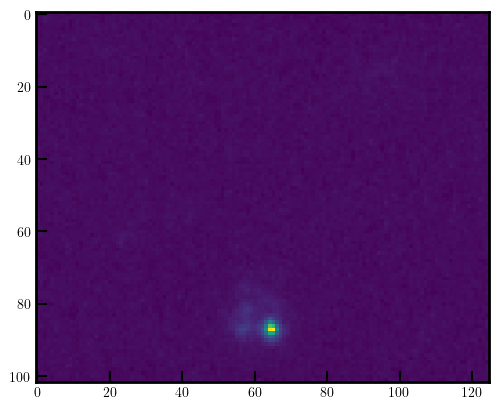

In [58]:
plt.imshow(peak_cutout_filt0_arr[20].data)

# Define the number of rows and columns for the grid


# Create the figure
if use_control == True:
    rows, cols = 14, 5  # Adjusted to fit 60 images
    fig = plt.figure(figsize=(15, 36))  # Adjusted height for better spacing
    ra_list  = sample_data['ra']  # List of RA values in degrees
    dec_list = sample_data['dec']  # List of Dec values in degrees

    cropped_img_with_source_filt0_arr  = peak_cutout_filt0_arr

else:
    rows, cols = 6, 5  # Adjusted to fit 60 images
    fig = plt.figure(figsize=(15, 15))  # Adjusted height for better spacing
    ra_list  = sample_data['ra']  # List of RA values in degrees
    dec_list = sample_data['dec']  # List of Dec values in degrees

    cropped_img_with_source_filt0_arr  = peak_cutout_filt0_arr


#fig.suptitle(r'\rm f336 galaxies', fontsize=20, fontweight='bold', y=1.01)

# Global min and max for scaling
use_control = True
vmin, vmax = -1, 1
# Define the normalization with a threshold for linear scaling
norm = SymLogNorm(linthresh=0.1, linscale=0.5, vmin=vmin, vmax=vmax)
# Example RA/Dec values

# Iterate over images and create individual WCS subplots
for i in range(rows * cols):
    if i < len(cropped_img_with_source_filt0_arr):
        # Extract the correct WCS for this image
        if use_control == True:
            wcs = cropped_img_with_source_filt0_arr[i].wcs  # Assuming this is a list of WCS objects
        else:
            wcs = cropped_img_with_source_filt0_arr[i].wcs  # Assuming this is a list of WCS objects
        # Create subplot with WCS projection
        ax = fig.add_subplot(rows, cols, i+1, projection=wcs)

        # Convert RA/Dec to pixel coordinates for this specific WCS
        x_pix, y_pix = wcs.world_to_pixel_values(ra_list[i], dec_list[i])

        # Plot the image with consistent scaling
        ax.imshow(cropped_img_with_source_filt0_arr[i].data, 
                  origin='lower', cmap='gray', norm=norm)
        #ax.imshow(cropped_mask[i], origin='lower', alpha=0.2)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Overlay converted pixel coordinates
        ax.scatter(x_pix, y_pix, marker='x', color='red', s=20, label="Source")

        # Annotate with RA/Dec values
        #ax.annotate(f"({ra_list[i]:.2f}, {dec_list[i]:.2f})", 
        #            (x_pix, y_pix), fontsize=6, color='yellow', ha='right')

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax = fig.add_subplot(rows, cols, i+1)  # Empty subplot
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)
plt.show()



In [52]:
#img_with_source_wts0_arr_2 = np.array([peak_cutout_wts0_arr[good_ind_2[i]].data for i in range(len(good_ind_2))])
#img_with_source_wts1_arr_2 = np.array([peak_cutout_wts1_arr[good_ind_2[i]].data for i in range(len(good_ind_2))])
#rounds=1
#np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts0_arr_2_' + 'eelgs', img_with_source_wts0_arr_2 ,)
#np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts1_arr_2_' + 'eelgs', img_with_source_wts1_arr_2 ,)
#img_with_source_wts0_arr_2  = get_cleaned_data(arr=img_with_source_wts0_arr_2,   arr_ind=good_ind)
#img_with_source_wts1_arr_2  = get_cleaned_data(arr=img_with_source_wts1_arr_2,   arr_ind=good_ind)

In [53]:
good_ind  = np.arange(len(sample_data))
if err_ind.size !=0:
    good_ind  = np.delete(good_ind, err_ind)
#good_ind = np.delete(good_ind, good_segmentation_index)

In [54]:
good_ind_2.shape

(26,)

In [55]:
#good_ind_2 = np.delete(good_ind, 20)

In [26]:
tol = 0.0003
if use_control == True:
    cat_indx_match = np.load('cat_matching_index_tol_control_%s.npy'%tol, allow_pickle=True)
else:
    cat_indx_match = np.load('cat_matching_index_tol_eelgs_%s.npy'%tol, allow_pickle=True)
    
catalog_ids = c0[-1].data['ID']
phot_z      = c0[-1].data['EAZY_z_a']
z_68l       = c0[-1].data['EAZY_l68']
z_68u       = c0[-1].data['EAZY_u68']
z_95l       = c0[-1].data['EAZY_l95']
z_95u       = c0[-1].data['EAZY_u95']
z_99l       = c0[-1].data['EAZY_l99']
z_99u       = c0[-1].data['EAZY_u99']
#control_ids = data['id'].astype(int)
#ind_ = np.where((z_99u - z_99l) < 0.2)[0]
#

#phot_z_arr= []
#z_68l_arr = []
#z_68u_arr = []
#z_95l_arr = []
#z_95u_arr = []
#z_99l_arr = []
#z_99u_arr = []
#for i in range(len(c0[-1].data['ID'])):
#    #catalog_ids = catalog_ids[ind_]
#    
#    try:
#        #print(int(predicted_match[i][0]))
#        phot_z_arr     .append(phot_z     [int(predicted_match[i][0])])
#        z_68l_arr      .append(z_68l      [int(predicted_match[i][0])])
#        z_68u_arr      .append(z_68u      [int(predicted_match[i][0])])
#        z_95l_arr      .append(z_95l      [int(predicted_match[i][0])])
#        z_95u_arr      .append(z_95u      [int(predicted_match[i][0])])
#        z_99l_arr      .append(z_99l      [int(predicted_match[i][0])])
#        z_99u_arr      .append(z_99u      [int(predicted_match[i][0])])
#    except:
#        #print(predicted_match[i][0])
#        pass
#phot_z_arr = np.array(phot_z_arr)
#z_68l_arr  = np.array(z_68l_arr )
#z_68u_arr  = np.array(z_68u_arr )
#z_95l_arr  = np.array(z_95l_arr )
#z_95u_arr  = np.array(z_95u_arr )
#z_99l_arr  = np.array(z_99l_arr )
#z_99u_arr  = np.array(z_99u_arr )

In [27]:
if len(err_ind) != 0:
    cat_indx_match = np.delete(cat_indx_match, err_ind, axis=0)

In [28]:
bad_indx_eelgs= np.array([11, 24]) # control sample
bad_indx_ctrl = np.array([5, 25, 45, 54, 59, 60, 73, 81]) # control sample

In [29]:
good_ind.shape, cat_indx_match.shape

((27,), (27, 2))

# Calculate rows and columns for subplots
n_rows = (good_ind.size + 2) // 3  # Ensure proper rows if good_ind.size is not divisible by 3
n_cols = 3

# Create subplots with WCS projection
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(15, 5 * n_rows),
    subplot_kw={'projection': peak_cutout_filt0_arr[0].wcs}  # Use the first WCS as the default
)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for ind in range(len(good_ind)):
    ax = axes[ind]  # Select the current subplot

    # Determine coordinates based on the control flag
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[ind]], dec=sample_data['dec'][good_ind[ind]], unit="deg")
    else:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[ind]], dec=sample_data['dec'][good_ind[ind]], unit="deg")

    # Convert world coordinates to pixel coordinates
    pixel_coords = peak_cutout_filt0_arr[ind].wcs.world_to_pixel(coordinates)

    # Check for matched catalog indices
    if len(cat_indx_match[ind]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[ind][0]]['ra'], c0[2].data[cat_indx_match[ind][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = peak_cutout_filt0_arr[ind].wcs.world_to_pixel(coordinates_s)
        phot_zz = c0[-1].data[cat_indx_match[ind][0]]['EAZY_z_a']
        z99ll = z_99l[cat_indx_match[ind][0]]
        z99ul = z_99u[cat_indx_match[ind][0]]

    # Set axis labels
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

    # Display the image data
    ax.imshow(
        peak_cutout_filt0_arr[ind].data,
        vmax=0.1, vmin=-0.1,
        origin='lower', cmap='cividis',
        alpha=0.7, aspect='equal'
    )

    # Plot the source
    ax.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'$\rm zfourge-z={sample_data["zphot"][good_ind[ind]]}$')

    # Plot matched catalog sources if they exist
    if len(cat_indx_match[ind]) != 0:
        for indd in range(len(z99ul)):
            ax.plot(
                pixel_coords_s[0][indd], pixel_coords_s[1][indd], 'd', markersize=5,
                label=rf'$\rm JADES-z={phot_zz[indd]:.3f}, {z99ll[indd]:.3f}< z_{{99\%}}^{{CI}}<{z99ul[indd]:.3f}$'
            )

    # Add legend to the subplot
    ax.legend()

# Turn off any unused axes
for ax in axes[len(good_ind):]:
    ax.axis('off')

# Adjust layout and save the figure
plt.tight_layout()
output_file = 'Z_fourge_JADES_control.jpg' if use_control else 'Z_fourge_JADES_eelgs.jpg'
plt.savefig(output_file, bbox_inches='tight', dpi=120)
plt.show()


In [30]:
phot_zz_arr = []
z99ll_arr = []
for ind in range(len(good_ind)):
    phot_zz = c0[-1].data[cat_indx_match[ind][0]]['EAZY_z_a']
    z99ll = z_99l[cat_indx_match[ind][0]]
    z99ul = z_99u[cat_indx_match[ind][0]]
    print(phot_zz, z99ll)
            
    #print(phot_zz, z99ll)

[3.52] [0.404]
[3.8  0.19] [3.75 0.01]
[3.69] [3.528]
[3.63 3.6  4.33 6.95 0.99 3.7 ] [3.45  3.54  0.468 0.447 0.025 3.532]
[3.42 5.66] [3.305 0.319]
[] []
[0.82 1.99 3.43 0.22 1.47 3.43] [0.013 1.648 3.385 0.146 0.015 3.331]
[3.15 3.57 3.68] [0.107 0.41  3.222]
[3.38 3.41 0.46 3.38 2.05] [0.529 3.103 0.241 0.085 0.012]
[3.85 4.71 3.98] [3.636 4.236 3.776]
[3.38 1.14 0.24] [3.09  0.708 0.015]
[3.67] [3.22]
[3.82 3.37] [3.019 0.53 ]
[1.23 3.11 3.41] [0.219 2.987 3.322]
[3.38] [0.442]
[3.27] [3.157]
[3.54 3.59] [0.228 3.208]
[3.71] [3.172]
[3.22 3.36] [2.982 3.082]
[3.36] [3.194]
[] []
[3.62] [3.336]
[0.33 3.72 4.33 1.54] [0.02  3.526 0.192 1.203]
[3.67 3.66] [1.574 3.509]
[3.29 3.29] [3.213 3.178]
[3.72 3.72] [3.404 3.452]
[4.24 0.91] [3.255 0.098]


In [ ]:
def get_segments_background(peak_cutout_data_arr, box_size_, filt_size, npixels, nlevels, contrast):  
    bkg_estimator = SExtractorBackground()
    segment_map_arr = []
    data_sub_arr = []
    convolved_data_arr = []
    
    for i in range(len(peak_cutout_data_arr)):
        try:
            bkg = Background2D(peak_cutout_data_arr[i].data, box_size=(box_size_, box_size_),\
                               filter_size=(filt_size, filt_size),
                               bkg_estimator=bkg_estimator)
            data_sub_arr.append(peak_cutout_data_arr[i].data - bkg.background)  # subtract the background
            
            kernel = make_2dgaussian_kernel(2.5, size=3)  # FWHM = 3.0
            convolved_data_arr.append(convolve(data_sub_arr[i], kernel))
            mean, median, std = sigma_clipped_stats(data_sub_arr[i], sigma=3.0) 
    
            segment_map_arr.append(detect_sources(convolved_data_arr[i], threshold=std, npixels=10))
        except Exception as e:
            print(f"Error in segment creation at index {i}: {e}")
    
    segm_deblend_arr = []
    for i in range(len(peak_cutout_data_arr)):
        try:
            segm_deblend_arr.append(deblend_sources(convolved_data_arr[i], segment_map_arr[i],
                                                    npixels=npixels, nlevels=nlevels, contrast=contrast,
                                                    progress_bar=False))
        except Exception as e:
            print(f"Error in deblending at index {i}: {e}")
            
    background_filled_arr = []
    for i in range(len(peak_cutout_data_arr)):
        try:
            background_filled_arr.append(fill_masked_with_noise(image=data_sub_arr[i],
                                                                 mask=~segm_deblend_arr[i].data_ma.mask))
        except Exception as e:
            print(f"Error in background filling at index {i}: {e}")
    
    masked_image_arr, closest_mask_arr, merged_other_masks_arr = [], [], []
    for i in range(len(peak_cutout_data_arr)):
        try:
            masked_image, closest_mask, merged_other_masks = apply_closest_mask(data=data_sub_arr[i],
                                                                                segment=segm_deblend_arr[i])
            masked_image_arr.append(masked_image)
            closest_mask_arr.append(closest_mask)
            merged_other_masks_arr.append(merged_other_masks)
        except Exception as e:
            print(f"Error in masking at index {i}: {e}")
            
    background_filled_arr2 = []
    for i in range(len(peak_cutout_data_arr)):
        try:
            background_filled_arr2.append(fill_masked_with_noise(image=data_sub_arr[i],
                                                                  mask=merged_other_masks_arr[i]))
        except Exception as e:
            print(f"Error in second background filling at index {i}: {e}")
            
    background_filled_arr3 = []
    for i in range(len(peak_cutout_data_arr)):
        try:
            background_filled_arr3.append(np.ma.masked_array(background_filled_arr[i], 
                                                              mask=closest_mask_arr[i], fill_value=np.nan))
        except Exception as e:
            print(f"Error in third background filling at index {i}: {e}")
            
    return segm_deblend_arr, segment_map_arr, data_sub_arr, convolved_data_arr, closest_mask_arr, background_filled_arr2, background_filled_arr3


In [ ]:
for i in range(len(good_ind)):
    #print(i, peak_cutout_filt0_arr[i].data.shape, peak_cutout_wts0_arr[i].data.shape, peak_cutout_filt1_arr[i].data.shape, peak_cutout_wts1_arr[i].data.shape )
    if peak_cutout_filt0_arr[i].data.shape  != peak_cutout_filt0_arr[0].data.shape:
        bad_ind = i
        print(bad_ind)

In [ ]:
def process_array(arr_list, bad_ind, target_shape):
    """
    Processes an array list by setting `bad_ind` to NaN and then restoring its data.

    Parameters:
    - arr_list: List of arrays to process.
    - bad_ind: Index of the bad data to process.
    - target_shape: Target shape for the NaN-filled array.

    Returns:
    - Updated list of arrays.
    """
    # Extract data
    arr_data = [arr.data for arr in arr_list]

    # Backup and replace with NaNs
    temp_data = np.copy(arr_data[bad_ind])
    arr_data[bad_ind] = np.full(target_shape, np.nan)

    # Restore the original data into the NaN-filled array
    arr_data[bad_ind][:temp_data.shape[0], :temp_data.shape[1]] = temp_data

    return arr_data

# Assuming all peak_cutout arrays have the same target shape
target_shape = peak_cutout_filt0_arr[0].data.shape

# Process each array
#peak_cutout_filt0_arr_data = process_array(peak_cutout_filt0_arr, bad_ind, target_shape)
#peak_cutout_wts0_arr_data = process_array(peak_cutout_wts0_arr, bad_ind, target_shape)
#peak_cutout_filt1_arr_data = process_array(peak_cutout_filt1_arr, bad_ind, target_shape)
#peak_cutout_wts1_arr_data = process_array(peak_cutout_wts1_arr, bad_ind, target_shape)


In [ ]:
ra = sample_data['ra'][good_ind_2]
peak_cutout_filt0_arr = np.delete(peak_cutout_filt0_arr, 20)

In [ ]:
plt.imshow(peak_cutout_filt0_arr[0].data - data_sub_arr[0])
plt.colorbar()

In [ ]:
segm_deblend_arr, segment_arr, data_sub_arr, convolved_data_arr, closest_mask_arr, background_filled_arr2, background_filled_arr3 = get_segments_background(peak_cutout_filt0_arr,\
                                                                                                                                               box_size_=8,\
                                                                                                                                               filt_size=7,\
                                                                                                                                               npixels=20,\
                                                                                                                                               nlevels=20,\
                                                                                                                                               contrast=0.001)

In [ ]:
segm_deblend_arr2, segment_arr2, data_sub_arr2, convolved_data_arr2, closest_mask_arr2, background_filled_arr22, background_filled_arr32 = get_segments_background(peak_cutout_filt1_arr,\
                                                                                                                                               box_size_=8,\
                                                                                                                                               filt_size=7,\
                                                                                                                                               npixels=20,\
                                                                                                                                               nlevels=20,\
                                                                                                                                               contrast=0.001)

In [ ]:
plt.imshow(np.ma.masked_equal(peak_cutout_filt1_arr[3].data, value=0))

# Set up a grid of 27 rows and 2 columns
fig, axes = plt.subplots(nrows=len(data_sub_arr), ncols=2, figsize=(10, len(data_sub_arr) * 5))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Loop through each pair of images and plot them side by side
for i in range(len(data_sub_arr)):
    # Plot the first image (data_sub_arr) in the left column
    ax0 = plt.subplot(len(data_sub_arr), 2, 2 * i + 1, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(data_sub_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')
    ax0.set_title(f"Source {i + 1}")
    
    # Plot the second image (segment_map_arr) in the right column
    ax1 = plt.subplot(len(data_sub_arr), 2, 2 * i + 2, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(segm_deblend_arr[i], origin='lower', cmap='cividis', interpolation='nearest', alpha=0.7)
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]')
    ax1.set_title(f"Segment Map {i + 1}")
    
    # Add a color bar for each subplot (optional)
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Segment Value')
# Save the entire figure
if use_control == True:
    
    plt.savefig('source_control_cut_seg_%s.jpg'%filt0)
else:
    plt.savefig('source_eelgs_cut_seg_%s.jpg'%filt0)
plt.show()

# Set up a grid of 27 rows and 3 columns
fig, axes = plt.subplots(nrows=len(data_sub_arr), ncols=3, figsize=(15, len(data_sub_arr) * 5))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=.3, wspace=.3)

# Loop through each set of images and plot them in the corresponding row
for i in range(len(data_sub_arr)):
    # Plot the first image (data_sub_arr) in the left column
    ax0 = plt.subplot(len(data_sub_arr), 3, 3 * i + 1, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(data_sub_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')
    ax0.set_title(f"Source {i + 1}")
    
    # Plot the second image (background_filled_arr) in the middle column
    ax1 = plt.subplot(len(data_sub_arr), 3, 3 * i + 2, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(background_filled_arr3[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]', visible=False)
    ax1.set_title(f"Source Subtracted {i + 1}")
    
    # Plot the third image (segment_map_arr) in the right column
    ax2 = plt.subplot(len(data_sub_arr), 3, 3 * i + 3, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax2.imshow(segm_deblend_arr[i], origin='lower', cmap='cividis', interpolation='nearest', alpha=0.7)
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)
    ax2.set_title(f"Segment Map {i + 1}")
    
    # Add a color bar for each subplot
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Background Level')

    cbar2 = plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Segment Value')

# Save the entire figure
if use_control:
    plt.savefig(f'source_control_cut_seg_rem_src_{filt0}.jpg')
else:
    plt.savefig(f'source_eelgs_cut_seg_rem_src_{filt0}.jpg')

# Display the plot
plt.show()


In [ ]:
def mask_highz_galaxies(data, segment, wcs, galaxy_ra, galaxy_dec, galaxy_redshifts, z_lim=3.08):
    """
    Masks galaxies with redshift > z_lim based on their RA/Dec coordinates in the WCS image.

    Parameters:
        data (numpy.ndarray): The 2D image array.
        segment (photutils.segmentation.SegmentationImage): The segmentation object with labeled masks.
        wcs (astropy.wcs.WCS): The WCS object corresponding to the data and segment images.
        galaxy_ra (array-like): RA values of the galaxies in degrees.
        galaxy_dec (array-like): Dec values of the galaxies in degrees.
        galaxy_redshifts (array-like): Redshift values of the galaxies.
        z_lim (float, optional): The redshift threshold to mask galaxies. Default is 3.08.

    Returns:
        masked_image (numpy.ndarray): The image with all high-redshift galaxies masked.
        combined_highz_mask (numpy.ndarray): A combined mask of all high-redshift galaxies.
        other_segments_mask (numpy.ndarray): A combined mask of all segments not included in the high-z mask.
    """
    # Convert galaxy RA/Dec to pixel coordinates using WCS
    galaxies_coords = SkyCoord(ra=galaxy_ra, dec=galaxy_dec, unit="deg")
    galaxy_pixels = wcs.world_to_pixel(galaxies_coords)
    galaxy_x, galaxy_y = galaxy_pixels[0], galaxy_pixels[1]

    # Identify galaxies with redshift > z_lim
    high_z_indices = np.where(galaxy_redshifts > z_lim)[0]
    high_z_x = galaxy_x[high_z_indices]
    high_z_y = galaxy_y[high_z_indices]

    # Initialise a combined mask for high-z galaxies
    combined_highz_mask = np.zeros_like(segment.data, dtype=bool)

    # Loop through all high-redshift galaxies
    for x, y in zip(high_z_x, high_z_y):
        # Convert pixel coordinates to integer
        x = int(round(x))
        y = int(round(y))

        # Ensure the coordinates are within image bounds
        if 0 <= x < data.shape[1] and 0 <= y < data.shape[0]:
            # Find the segment label corresponding to this pixel
            label = segment.data[y, x]
            if label > 0:  # Exclude background (label 0)
                # Add the current segment to the combined high-z mask
                combined_highz_mask |= (segment.data == label)

    # Create the masked image by setting high-z galaxy regions to NaN
    masked_image = np.where(combined_highz_mask, np.nan, data)

    # Create a mask for all other segments not included in the high-z mask
    other_segments_mask = (segment.data > 0) & ~combined_highz_mask

    return masked_image, combined_highz_mask, other_segments_mask

# Example usage:
# masked_image, combined_mask, other_segments = mask_highz_galaxies(data, segment, wcs, galaxy_ra, galaxy_dec, galaxy_redshifts)


In [ ]:
masked_image_arr, combined_highz_mask_arr, other_segments_mask_arr = [], [], []

for ind in range(good_ind.size):
    ra_s, dec_s = c0[2].data[cat_indx_match[ind][0]]['ra'], c0[2].data[cat_indx_match[ind][0]]['dec']
    coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
    pixel_coords_s = peak_cutout_filt0_arr[ind].wcs.world_to_pixel(coordinates_s)
    phot_zz = c0[-1].data[cat_indx_match[ind][0]]['EAZY_z_a']
    z99ll = z_99l[cat_indx_match[ind][0]]
    z99ul = z_99u[cat_indx_match[ind][0]]
    masked_image, combined_highz_mask, other_segments_mask = mask_highz_galaxies(data=data_sub_arr[ind], segment=segm_deblend_arr[ind], wcs=peak_cutout_filt0_arr[ind].wcs,\
                                                                         galaxy_ra=ra_s, galaxy_dec=dec_s, galaxy_redshifts=phot_zz, z_lim=3.08)
    
    masked_image_arr       .append(masked_image)
    combined_highz_mask_arr.append(combined_highz_mask)
    other_segments_mask_arr.append(other_segments_mask)

In [ ]:
len(masked_image_arr), len(combined_highz_mask_arr), len(other_segments_mask_arr)

# Set up a grid of 27 rows and 3 columns
fig, axes = plt.subplots(nrows=len(masked_image_arr), ncols=3, figsize=(15, len(data_sub_arr) * 5))

good_segmentation_index = np.array([1, 2, 4, 5, 6, 7, 10,11,13,14,15,16,17,19,21, 
                                    22,24,25,27,28,29,30,31,34,35,36,37,39,40,41,43,44,45,46,47,48,
                                   49,50,54,55,56,57,58,59,64,65,66,68,70,71,72,73,76,
                                   77,78,79,80,81,82,83]) -1
# Adjust spacing between subplots
fig.subplots_adjust(hspace=.3, wspace=.3)

# Loop through each set of images and plot them in the corresponding row
for i in good_segmentation_index:
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")
    else:
        coordinates = SkyCoord(ra=sample_data['RA'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")

    # Convert world coordinates to pixel coordinates
    pixel_coords = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates)

    # Check for matched catalog indices
    if len(cat_indx_match[i]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[i][0]]['ra'], c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates_s)
        phot_zz = c0[-1].data[cat_indx_match[i][0]]['EAZY_z_a']
        z99ll = z_99l[cat_indx_match[i][0]]
        z99ul = z_99u[cat_indx_match[i][0]]

    # Plot the first image (data_sub_arr) in the left column
    ax0 = plt.subplot(len(data_sub_arr), 3, 3 * i + 1, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(data_sub_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')
    ax0.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'$\rm zfourge-z={sample_data["zphot"][good_ind[ind]]}$')

    # Plot matched catalog sources if they exist
    if len(cat_indx_match[i]) != 0:
        for indd in range(len(z99ul)):
            ax0.plot(
                pixel_coords_s[0][indd], pixel_coords_s[1][indd], 'd', markersize=5,
                label=rf'$\rm JADES-z={phot_zz[indd]:.3f}, {z99ll[indd]:.3f}< z_{{99\%}}^{{CI}}<{z99ul[indd]:.3f}$'
            )

    # Add legend to the subplot
    ax0.legend(fontsize=8, framealpha=0)
    ax0.set_title(f"Source {i + 1}")
    
    # Plot the second image (background_filled_arr) in the middle column
    ax1 = plt.subplot(len(data_sub_arr), 3, 3 * i + 2, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(masked_image_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]', visible=False)
    ax1.set_title("Source Subtracted")
    
    # Plot the third image (segment_map_arr) in the right column
    ax2 = plt.subplot(len(data_sub_arr), 3, 3 * i + 3, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax2.imshow(other_segments_mask_arr[i], origin='lower', cmap='cividis', interpolation='nearest', alpha=0.7)
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)
    ax2.set_title(f"remaining Segments {i + 1}")
    
    # Add a color bar for each subplot
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Flux Density [%s]' % flux_units)

    cbar2 = plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Mask')

# Save the entire figure
if use_control:
    plt.savefig(f'source_z_mask_control_cut_seg_rem_src_{filt0}.jpg')
else:
    plt.savefig(f'source_z_mask_eelgs_cut_seg_rem_src_{filt0}.jpg')

# Display the plot
    
plt.show()


In [ ]:
def fill_masked_with_noise2(image, source_mask, background_mask):
    """
    Fills masked regions of an image with noise matching the unmasked regions.

    Parameters:
    - image (numpy.ndarray): The input image.
    - mask (numpy.ndarray): A boolean mask where True indicates masked pixels.

    Returns:
    - numpy.ndarray: The image with masked regions filled with noise.
    """
    if image.shape != source_mask.shape != background_mask.shape:
        raise ValueError("Image and mask must have the same shape.")

    # Create a masked array
    mask_ = source_mask+background_mask
    masked_image = np.ma.masked_array(image, mask=mask_)
    
    # Calculate noise level (standard deviation of unmasked pixels)
    noise_level = np.nanstd(masked_image.compressed())
    noise_loc   = np.nanmean(masked_image.compressed())
    
    # Generate noise for masked pixels
    random_noise = np.random.normal(loc=noise_loc, scale=noise_level, size=image.shape)
    
    # Create a copy of the original image to modify
    noisy_image = image.copy()
    
    noisy_image[mask_] = random_noise[mask_]
    image[background_mask] = random_noise[background_mask]
    return noisy_image, image

In [ ]:
def process_images_with_masks(data_arrays, source_masks, background_masks, good_indices, fill_masked_function, filt=True):
    """
    Applies a masking function to a list of data arrays, separating noise and sources.

    Parameters:
    - data_arrays: List of input data arrays to process.
    - source_masks: List of source masks corresponding to each array.
    - background_masks: List of background masks corresponding to each array.
    - good_indices: Indices of arrays to process.
    - fill_masked_function: Function for filling masked regions with noise and extracting sources.

    Returns:
    - img_only_noise_list: List of images with only noise.
    - img_with_source_list: List of images with sources included.
    """
    img_only_noise_list = []
    img_with_source_list = []

    for i in range(len(good_indices)):
        if filt == True:
            data = data_arrays[i].data
        else:
            data = data_arrays[i]
        try:
            
            img_only_noise, img_with_source = fill_masked_function(
                image=data,
                source_mask=source_masks[i],
                background_mask=background_masks[i]
            )
            img_with_source_list.append(img_with_source)
            img_only_noise_list.append(img_only_noise)
        except Exception as e:
            print(f"Error processing index {i}: {e}")
            continue

    return img_only_noise_list, img_with_source_list




In [ ]:
#bkg_estimator = SExtractorBackground()
data_sub_wts0_arr       = []
data_sub_wts1_arr       = []
for i in range(len(good_ind)):
    try:
        #bkg = Background2D(peak_cutout_wts0_arr[i].data, box_size=(10, 10), filter_size=(5, 5),
        #                      bkg_estimator=bkg_estimator)
        data_sub_wts0_arr.append (peak_cutout_wts0_arr[i].data)# - bkg.background)  # subtract the background
        data_sub_wts1_arr.append (peak_cutout_wts1_arr[i].data)
        #print(i, peak_cutout_wts0_arr[i].data.shape, bkg.background.shape)
    except:
        print('bkg_rem err', i)
# Process for different arrays 
# img_only_noise_filt0_arr, img_with_source_filt0_arr already done
img_only_noise_wts0_arr, img_with_source_wts0_arr = process_images_with_masks(
    data_arrays=peak_cutout_wts0_arr,
    source_masks=combined_highz_mask_arr,
    background_masks=other_segments_mask_arr,
    good_indices=good_ind,
    fill_masked_function=fill_masked_with_noise2, filt=True)

img_only_noise_wts1_arr, img_with_source_wts1_arr = process_images_with_masks(
    data_arrays=peak_cutout_wts1_arr,
    source_masks=combined_highz_mask_arr,
    background_masks=other_segments_mask_arr,
    good_indices=good_ind,
    fill_masked_function=fill_masked_with_noise2, filt=True)

In [ ]:
plt.imshow(img_with_source_wts0_arr[1])

In [ ]:
plt.imshow(img_only_noise_wts0_arr[1])

In [ ]:
img_only_noise_filt0_arr, img_with_source_filt0_arr = [], []
for i in range(good_ind.size):
    img_only_noise, img_with_source = fill_masked_with_noise2(image=data_sub_arr[i], source_mask=combined_highz_mask_arr[i], background_mask=other_segments_mask_arr[i])
    
    img_with_source_filt0_arr    .append(img_with_source)
    img_only_noise_filt0_arr     .append(img_only_noise)
    
img_only_noise_filt1_arr, img_with_source_filt1_arr = [], []
for i in range(good_ind.size):
    img_only_noise, img_with_source = fill_masked_with_noise2(image=data_sub_arr2[i], source_mask=combined_highz_mask_arr[i], background_mask=other_segments_mask_arr[i])
    
    img_with_source_filt1_arr    .append(img_with_source)
    img_only_noise_filt1_arr     .append(img_only_noise)
    



In [ ]:
#bkg_estimator = SExtractorBackground()
#peak_cutout_filt1_arr_       = []
#for i in range(len(good_ind)):
#    try:
#        bkg = Background2D(peak_cutout_filt1_arr[i].data, box_size=(10, 10), filter_size=(5, 5),
#                              bkg_estimator=bkg_estimator)
#        peak_cutout_filt1_arr_.append (peak_cutout_filt1_arr[i].data - bkg.background)  # subtract the background
#        #print(i, peak_cutout_wts0_arr[i].data.shape, bkg.background.shape)
#    except:
#        print('bkg_rem err', i)

In [ ]:
#img_only_noise_filt1_arr, img_with_source_filt1_arr = process_images_with_masks(
#    data_arrays=peak_cutout_filt1_arr_,
#    source_masks=combined_highz_mask_arr,
#    background_masks=other_segments_mask_arr,
#    good_indices=good_ind,
#    fill_masked_function=fill_masked_with_noise2, filt=False)
#


from matplotlib.colors import SymLogNorm

#norm=LogNorm(vmin=data.min()+1e-6, vmax=data.max())

# Add colorbar
# Define the number of rows and columns for the grid
rows, cols = 5, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

fig.suptitle(r'\rm f814 weights', fontsize=20, fontweight='bold', y=1.01)
# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
#all_images = np.array(peak_cutout_wts0_arr)  # Assuming this is the list/array of images


# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(peak_cutout_wts0_arr):
        # Plot the image with consistent scaling
        ax.imshow(peak_[i].data, origin='lower', cmap='gray', norm=LogNorm(vmin=peak_cutout_wts0_arr[i].data.min()+1e-6, vmax=peak_cutout_wts0_arr[i].data.max()))
        #ax.imshow(mask_arr[i], origin='lower', alpha=0.2)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=-0.1, h_pad=0.01, w_pad=0.01)
#plt.savefig('control_gal_samples_final_f336.jpg', bbox_inches='tight', dpi=220)
# Show the plot
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

#norm=LogNorm(vmin=data.min()+1e-6, vmax=data.max())

# Add colorbar
# Define the number of rows and columns for the grid
rows, cols = 5, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

fig.suptitle(r'\rm f814 weights', fontsize=20, fontweight='bold', y=1.01)
# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
#all_images = np.array(peak_cutout_wts0_arr)  # Assuming this is the list/array of images


# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(img_only_noise_wts0_arr):
        # Plot the image with consistent scaling
        ax.imshow(img_with_source_wts0_arr[i], origin='lower', cmap='gray', norm=LogNorm(vmin=img_only_noise_wts0_arr[i].min()+1e-6, vmax=img_only_noise_wts0_arr[i].max()))
        #ax.imshow(mask_arr[i], origin='lower', alpha=0.2)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=-0.1, h_pad=0.01, w_pad=0.01)
#plt.savefig('control_gal_samples_final_f336.jpg', bbox_inches='tight', dpi=220)
# Show the plot
plt.show()

In [ ]:
plt.plot(img_only_noise_wts0_arr[0].reshape(-1), 'o')
plt.plot(peak_cutout_wts0_arr[0].data.reshape(-1), '.')

In [ ]:
def get_cleaned_data(arr, arr_ind):
    arr_dummy = []
    for i in range(len(arr_ind)):
        arr_dummy.append(arr[arr_ind[i]])
    
    return np.array(arr_dummy)

In [ ]:
len(combined_highz_mask_arr), good_segmentation_index

In [ ]:
# for eelgs
mask_arr_                  = get_cleaned_data(arr=combined_highz_mask_arr ,   arr_ind=good_ind_2)

img_only_noise_filt0_arr_  = get_cleaned_data(arr=img_only_noise_filt0_arr ,  arr_ind=good_ind_2)
img_only_noise_filt1_arr_  = get_cleaned_data(arr=img_only_noise_filt1_arr ,  arr_ind=good_ind_2)

img_with_source_filt0_arr_ = get_cleaned_data(arr=img_with_source_filt0_arr,  arr_ind=good_ind_2)
img_with_source_filt1_arr_ = get_cleaned_data(arr=img_with_source_filt1_arr,  arr_ind=good_ind_2)

img_with_source_wts0_arr_  = get_cleaned_data(arr=img_with_source_wts0_arr,   arr_ind=good_ind_2)
img_with_source_wts1_arr_  = get_cleaned_data(arr=img_with_source_wts1_arr,   arr_ind=good_ind_2)

img_only_noise_wts0_arr_   = get_cleaned_data(arr=img_only_noise_wts0_arr,    arr_ind=good_ind_2)
img_only_noise_wts1_arr_   = get_cleaned_data(arr=img_only_noise_wts1_arr,    arr_ind=good_ind_2)

wcs_filt0_arr_             = get_cleaned_data(arr=peak_cutout_filt0_arr,      arr_ind=good_ind_2)
wcs_filt1_arr_             = get_cleaned_data(arr=peak_cutout_filt1_arr,      arr_ind=good_ind_2)

In [ ]:
for i in range(mask_arr_.shape[0]):
    print(i)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(img_with_source_wts0_arr_[i])
    
    plt.subplot(122)
    plt.imshow(mask_arr_[i])
    
    plt.show()

In [ ]:
data_sub_wts0_arr = np.array(data_sub_wts0_arr)

In [ ]:
good_segmentation_index

In [ ]:

np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts0_arr_' + 'eelgs', data_sub_wts0_arr ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts1_arr_' + 'eelgs', data_sub_wts1_arr ,)

In [ ]:
round_=1
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/mask_arr_'                 + 'eelgs', mask_arr_                 ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/good_index'                + 'eelgs', good_segmentation_index   ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/wcs_filt0_arr_'            + 'eelgs', wcs_filt0_arr_            ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/wcs_filt1_arr_'            + 'eelgs', wcs_filt1_arr_            ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt0_arr_' + 'eelgs', img_only_noise_filt0_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt1_arr_' + 'eelgs', img_only_noise_filt1_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_filt0_arr_'+ 'eelgs', img_with_source_filt0_arr_,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_filt1_arr_'+ 'eelgs', img_with_source_filt1_arr_,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts0_arr_' + 'eelgs', img_with_source_wts0_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts1_arr_' + 'eelgs', img_with_source_wts1_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_wts0_arr_'  + 'eelgs', img_only_noise_wts0_arr_  ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_wts1_arr_'  + 'eelgs', img_only_noise_wts1_arr_  ,)

In [ ]:
wcs_filt0_arr_.shape

In [ ]:
mask_arr_                 
good_segmentation_index   
wcs_filt0_arr_            
wcs_filt1_arr_            
img_only_noise_filt0_arr_ 
img_only_noise_filt0_arr_ 
img_with_source_filt0_arr_
img_with_source_wts0_arr_ 
img_only_noise_wts0_arr_  
img_only_noise_filt1_arr_ 
img_with_source_filt1_arr_
img_with_source_wts1_arr_ 
img_only_noise_wts1_arr_  

In [ ]:
mask_arr_

In [ ]:
# Assuming the WCS objects and image arrays are already defined
wcs_      =  np.array([wcs_filt0_arr_[i].wcs for i in range(len(wcs_filt0_arr_))])
wcs_data_ = np.array([wcs_filt0_arr_[i].data for i in range(len(wcs_filt0_arr_))])


# Stack images along the first axis (based on the length of the data)
stacked_filter0 = np.stack(img_with_source_filt0_arr_, axis=0)  # (n, 100, 100)
stacked_filter1 = np.stack(img_with_source_filt1_arr_, axis=0)
stacked_filter0n = np.stack(img_only_noise_filt0_arr_, axis=0)
stacked_filter1n = np.stack(img_only_noise_filt1_arr_, axis=0)
stacked_filter0w = np.stack(img_with_source_wts0_arr_, axis=0)
stacked_filter1w = np.stack(img_with_source_wts1_arr_, axis=0)

# Primary HDU (No WCS header)
primary_hdu = fits.PrimaryHDU(stacked_filter0)
primary_hdu.header['EXTNAME'] = 'F814-original'

# Mask HDU
mask_hdu = fits.ImageHDU(mask_arr_.astype(np.uint8))
mask_hdu.header['EXTNAME'] = 'F814-segments'

# Create ImageHDUs with the stacked arrays (without WCS headers)
filter0_hdu = fits.ImageHDU(stacked_filter0)
filter0_hdu.header['EXTNAME'] = 'F814'

filter1_hdu = fits.ImageHDU(stacked_filter1)
filter1_hdu.header['EXTNAME'] = 'F336'

filter0n_hdu = fits.ImageHDU(stacked_filter0n)
filter0n_hdu.header['EXTNAME'] = 'F814-background'

filter1n_hdu = fits.ImageHDU(stacked_filter1n)
filter1n_hdu.header['EXTNAME'] = 'F336-background'

filter0w_hdu = fits.ImageHDU(stacked_filter0w)
filter0w_hdu.header['EXTNAME'] = 'F814-weights'

filter1w_hdu = fits.ImageHDU(stacked_filter1w)
filter1w_hdu.header['EXTNAME'] = 'F336-weights'

# Create an HDU for each WCS object and add it to the list of HDUs
wcs_hdus = []
for i in range(len(wcs_filt0_arr_)):  # Dynamically based on the length of the data
    wcs_hdu = fits.ImageHDU(np.zeros((1, 1)))  # Placeholder data for WCS HDUs
    wcs_hdu.header['EXTNAME'] = f'WCS'
    wcs_hdu.header.update(wcs_[i].to_header())  # Add WCS header
    wcs_hdus.append(wcs_hdu)

# Create HDU list and save to a FITS file
hdul = fits.HDUList([
    primary_hdu, mask_hdu, filter0_hdu, filter1_hdu, 
    filter0n_hdu, filter1n_hdu, filter0w_hdu, filter1w_hdu
] + wcs_hdus)  # Append WCS HDUs to the list

hdul.writeto('EELGS_final.fits', overwrite=True)

print("FITS file 'EELGS_final.fits' created successfully.")


In [ ]:
from astropy.io import fits
from astropy.wcs import WCS

# Open the FITS file
hdul = fits.open('EELGS_final.fits')

# Extract WCS headers from the WCS HDUs
wcs_list = []
for i in range(len(wcs_filt0_arr_)):  # The number of WCS HDUs should match the number of WCS objects
    wcs_header = hdul[f'WCS'].header  # Access the header of each WCS HDU
    wcs_obj = WCS(wcs_header)  # Convert the header to a WCS object
    wcs_list.append(wcs_obj)

# Now you have a list of WCS objects
for i, wcs_obj in enumerate(wcs_list):
    print(f"WCS:")
    print(wcs_obj)  # Print WCS object to verify


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': wcs_list[0]})
ax.imshow(stacked_filter0[0], origin='lower', cmap='gray')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()


In [ ]:
#round 2

In [ ]:
good_ind

In [ ]:
good_segmentation_index

In [ ]:
bad_ind_after_round_1 = np.delete(np.arange(len(good_ind)), good_segmentation_index)

In [ ]:
bad_ind_after_round_1.shape

In [ ]:
bad_ind_after_round_1

In [ ]:
segm_deblend_arr, segment_arr, data_sub_arr, convolved_data_arr, closest_mask_arr, background_filled_arr2, background_filled_arr3 = get_segments_background(peak_cutout_filt0_arr,\
                                                                                                                                               box_size_=8,\
                                                                                                                                               filt_size=7,\
                                                                                                                                               npixels=20,\
                                                                                                                                               nlevels=20,\
                                                                                                                                               contrast=0.001)

In [ ]:
segm_deblend_arr, segment_arr, data_sub_arr, convolved_data_arr, closest_mask_arr, background_filled_arr2, background_filled_arr3 = get_segments_background(peak_cutout_filt0_arr,\
                                                                                                                                               box_size_=8,\
                                                                                                                                               filt_size=7,\
                                                                                                                                               npixels=10,\
                                                                                                                                               nlevels=10,\
                                                                                                                                               contrast=0.001)

In [ ]:
%matplotlib notebook

In [ ]:
seg_index_ctrl = np.array([5, 5, 9, 9, 8, 3, 5, 5, 7, 5, 3, 4, 5, 7, 8, 8, 8, 2, 3, 10, 5, 2, 5 ])

seg_index_eelgs = np.array([4, 2, 5, 3, 7, 4, 11, 9, 2, 4, 3, 4, 5, 7, 8, 8, 8, 2, 3, 10, 5, 2, 5 ])

In [ ]:
for i in range(good_ind.size):
    plt.figure(figsize=(8, 2))
    plt.subplot(121)
    plt.imshow(peak_cutout_filt0_arr[i].data, vmin=-0.1, vmax=0.1)
    
    plt.subplot(122)
    plt.imshow(segm_deblend_arr[i], cmap='Paired')
    #plt.colorbar(size=1)
    plt.show()

In [ ]:
def mask_highz_galaxies2(data, segment, target_labels):
    """
    Masks specified segments in an image and creates masks for other segments.

    Parameters:
        data (numpy.ndarray): The 2D image array.
        segment (photutils.segmentation.SegmentationImage): The segmentation object with labeled masks.
        target_labels (int or list of int): The segment label(s) to be masked.

    Returns:
        masked_image (numpy.ndarray): The image with specified segments masked.
        combined_mask (numpy.ndarray): A combined mask of the specified segments.
        other_segments_mask (numpy.ndarray): A combined mask of all segments not included in the target mask.
    """
    # Ensure target_labels is a list
    if isinstance(target_labels, int):
        target_labels = [target_labels]

    # Create the combined mask for the target labels
    combined_mask = np.isin(segment.data, target_labels)

    # Create the masked image by setting the specified segments to NaN
    masked_image = np.where(combined_mask, np.nan, data)

    # Create a mask for all other segments not included in the target labels
    other_segments_mask = (segment.data > 0) & ~combined_mask

    return masked_image, combined_mask, other_segments_mask

In [ ]:
seg_index = np.array([5, 5, 9, 9, 8, 3, 5, 5, 7, 5, 3, 4, 5, 7, 8, 8, 8, 2, 3, 10, 5, 2, 5, ])

In [ ]:
bad_ind_after_round_1.size, seg_index.size

In [ ]:
bad_ind_after_round_1

In [ ]:
seg_index_full = np.ones(good_ind.size,).astype(int)
seg_index_full[bad_ind_after_round_1] = seg_index

In [ ]:
seg_index_full, bad_ind_after_round_1

In [ ]:
masked_image_arr, combined_highz_mask_arr, other_segments_mask_arr = [], [], []

for ind in range(good_ind.size):
    ra_s, dec_s = c0[2].data[cat_indx_match[ind][0]]['ra'], c0[2].data[cat_indx_match[ind][0]]['dec']
    coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
    pixel_coords_s = peak_cutout_filt0_arr[ind].wcs.world_to_pixel(coordinates_s)
    phot_zz = c0[-1].data[cat_indx_match[ind][0]]['EAZY_z_a']
    z99ll = z_99l[cat_indx_match[ind][0]]
    z99ul = z_99u[cat_indx_match[ind][0]]
    masked_image, combined_highz_mask, other_segments_mask = mask_highz_galaxies2(data=peak_cutout_filt0_arr[ind].data, segment=segm_deblend_arr[ind], target_labels=seg_index_full[ind])
    
    masked_image_arr       .append(masked_image)
    combined_highz_mask_arr.append(combined_highz_mask)
    other_segments_mask_arr.append(other_segments_mask)

In [ ]:
for i in range(bad_ind_after_round_1.size):
    plt.figure(figsize=(8, 2))
    plt.subplot(121)
    plt.imshow(peak_cutout_filt0_arr[bad_ind_after_round_1[i]].data, vmin=-0.1, vmax=0.1)
    
    plt.subplot(122)
    plt.imshow(combined_highz_mask_arr[bad_ind_after_round_1[i]], cmap='Paired')
    #plt.colorbar(size=1)
    plt.show()

In [ ]:
img_only_noise_filt0_arr, img_with_source_filt0_arr = [], []
for i in range(good_ind.size):
    img_only_noise, img_with_source = fill_masked_with_noise2(image=data_sub_arr[i], source_mask=combined_highz_mask_arr[i], background_mask=other_segments_mask_arr[i])
    
    img_with_source_filt0_arr    .append(img_with_source)
    img_only_noise_filt0_arr     .append(img_only_noise)

bkg_estimator = SExtractorBackground()
data_sub_wts_arr       = []
for i in range(len(good_ind)):
    try:
        bkg = Background2D(peak_cutout_wts0_arr[i].data, box_size=(10, 10), filter_size=(5, 5),
                               bkg_estimator=bkg_estimator)
        data_sub_wts_arr.append (peak_cutout_wts0_arr[i].data - bkg.background)  # subtract the background
        #print(i, peak_cutout_wts0_arr[i].data.shape, bkg.background.shape)
    except:
        print('bkg_rem err', i)

def process_images_with_masks(data_arrays, source_masks, background_masks, good_indices, fill_masked_function, filt1=True):
    """
    Applies a masking function to a list of data arrays, separating noise and sources.

    Parameters:
    - data_arrays: List of input data arrays to process.
    - source_masks: List of source masks corresponding to each array.
    - background_masks: List of background masks corresponding to each array.
    - good_indices: Indices of arrays to process.
    - fill_masked_function: Function for filling masked regions with noise and extracting sources.

    Returns:
    - img_only_noise_list: List of images with only noise.
    - img_with_source_list: List of images with sources included.
    """
    img_only_noise_list = []
    img_with_source_list = []

    for i in range(len(good_indices)):
        if filt1 == True:
            data = data_arrays[i].data
        else:
            data = data_arrays[i]
        try:
            
            img_only_noise, img_with_source = fill_masked_function(
                image=data,
                source_mask=source_masks[i],
                background_mask=background_masks[i]
            )
            img_with_source_list.append(img_with_source)
            img_only_noise_list.append(img_only_noise)
        except Exception as e:
            print(f"Error processing index {i}: {e}")
            continue

    return img_only_noise_list, img_with_source_list

# Process for different arrays 
# img_only_noise_filt0_arr, img_with_source_filt0_arr already done
img_only_noise_wts0_arr, img_with_source_wts0_arr = process_images_with_masks(
    data_arrays=data_sub_wts_arr,
    source_masks=combined_highz_mask_arr,
    background_masks=other_segments_mask_arr,
    good_indices=good_ind,
    fill_masked_function=fill_masked_with_noise2, filt1=False)

img_only_noise_filt1_arr, img_with_source_filt1_arr = process_images_with_masks(
    data_arrays=peak_cutout_filt1_arr,
    source_masks=combined_highz_mask_arr,
    background_masks=other_segments_mask_arr,
    good_indices=good_ind,
    fill_masked_function=fill_masked_with_noise2
)

img_only_noise_wts1_arr, img_with_source_wts1_arr = process_images_with_masks(
    data_arrays=peak_cutout_wts0_arr,
    source_masks=combined_highz_mask_arr,
    background_masks=other_segments_mask_arr,
    good_indices=good_ind,
    fill_masked_function=fill_masked_with_noise2
)


In [ ]:
bad_ind_after_round_1

In [ ]:
bad_ind_after_round_1 = np.delete(bad_ind_after_round_1, 8)

In [ ]:
good_segmentation_index

In [ ]:
mask_arr_                   = get_cleaned_data(arr=combined_highz_mask_arr ,  arr_ind=bad_ind_after_round_1)
img_only_noise_filt0_arr_  = get_cleaned_data(arr=img_only_noise_filt0_arr ,  arr_ind=bad_ind_after_round_1)
img_with_source_filt0_arr_ = get_cleaned_data(arr=img_with_source_filt0_arr,  arr_ind=bad_ind_after_round_1)
img_with_source_wts0_arr_  = get_cleaned_data(arr=img_with_source_wts0_arr,   arr_ind=bad_ind_after_round_1)
img_only_noise_wts0_arr_   = get_cleaned_data(arr=img_only_noise_wts0_arr,    arr_ind=bad_ind_after_round_1)
img_only_noise_filt1_arr_  = get_cleaned_data(arr=img_only_noise_filt1_arr ,  arr_ind=bad_ind_after_round_1)
img_with_source_filt1_arr_ = get_cleaned_data(arr=img_with_source_filt1_arr,  arr_ind=bad_ind_after_round_1)
img_with_source_wts1_arr_  = get_cleaned_data(arr=img_with_source_wts1_arr,   arr_ind=bad_ind_after_round_1)
img_only_noise_wts1_arr_   = get_cleaned_data(arr=img_only_noise_wts1_arr,    arr_ind=bad_ind_after_round_1)
wcs_filt0_arr_   = get_cleaned_data(arr=peak_cutout_filt0_arr,                arr_ind=bad_ind_after_round_1)
wcs_filt1_arr_   = get_cleaned_data(arr=peak_cutout_filt1_arr,                arr_ind=bad_ind_after_round_1)

In [ ]:
round_=2
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/mask_arr_'                 + '%d'%round_, mask_arr_                 ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/good_index'                + '%d'%round_, bad_ind_after_round_1     ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/wcs_filt0_arr_'            + '%d'%round_, wcs_filt0_arr_            ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/wcs_filt1_arr_'            + '%d'%round_, wcs_filt1_arr_            ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt0_arr_' + '%d'%round_, img_only_noise_filt0_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt0_arr_' + '%d'%round_, img_only_noise_filt0_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_filt0_arr_'+ '%d'%round_, img_with_source_filt0_arr_,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts0_arr_' + '%d'%round_, img_with_source_wts0_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_wts0_arr_'  + '%d'%round_, img_only_noise_wts0_arr_  ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt1_arr_' + '%d'%round_, img_only_noise_filt1_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_filt1_arr_'+ '%d'%round_, img_with_source_filt1_arr_,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts1_arr_' + '%d'%round_, img_with_source_wts1_arr_ ,)
np.save('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_wts1_arr_'  + '%d'%round_, img_only_noise_wts1_arr_  ,)

In [ ]:
# Create a new list excluding the specified indices (removing good_segmentation indices)


In [ ]:
# Set up a grid of 27 rows and 3 columns
fig, axes = plt.subplots(nrows=len(masked_image_arr), ncols=3, figsize=(15, len(data_sub_arr) * 5))

good_segmentation_index = np.arange(len(masked_image_arr))
# Adjust spacing between subplots
fig.subplots_adjust(hspace=.3, wspace=.3)

# Loop through each set of images and plot them in the corresponding row
for i in good_segmentation_index:
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")
    else:
        coordinates = SkyCoord(ra=sample_data['RA'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")

    # Convert world coordinates to pixel coordinates
    pixel_coords = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates)

    # Check for matched catalog indices
    if len(cat_indx_match[i]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[i][0]]['ra'], c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates_s)
        phot_zz = c0[-1].data[cat_indx_match[i][0]]['EAZY_z_a']
        z99ll = z_99l[cat_indx_match[i][0]]
        z99ul = z_99u[cat_indx_match[i][0]]

    # Plot the first image (data_sub_arr) in the left column
    ax0 = plt.subplot(len(data_sub_arr), 3, 3 * i + 1, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(data_sub_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')
    ax0.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'$\rm zfourge-z={sample_data["zphot"][good_ind[ind]]}$')

    # Plot matched catalog sources if they exist
    if len(cat_indx_match[i]) != 0:
        for indd in range(len(z99ul)):
            ax0.plot(
                pixel_coords_s[0][indd], pixel_coords_s[1][indd], 'd', markersize=5,
                label=rf'$\rm JADES-z={phot_zz[indd]:.3f}, {z99ll[indd]:.3f}< z_{{99\%}}^{{CI}}<{z99ul[indd]:.3f}$'
            )

    # Add legend to the subplot
    ax0.legend(fontsize=8, framealpha=0)
    ax0.set_title(f"Source {i + 1}")
    
    # Plot the second image (background_filled_arr) in the middle column
    ax1 = plt.subplot(len(data_sub_arr), 3, 3 * i + 2, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(masked_image_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]', visible=False)
    ax1.set_title(r"$z > 3.08 \rm Source Subtracted {i + 1}$")
    
    # Plot the third image (segment_map_arr) in the right column
    ax2 = plt.subplot(len(data_sub_arr), 3, 3 * i + 3, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax2.imshow(other_segments_mask_arr[i], origin='lower', cmap='cividis', interpolation='nearest', alpha=0.7)
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)
    ax2.set_title(f"remaining Segments {i + 1}")
    
    # Add a color bar for each subplot
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Flux Density [%s]' % flux_units)

    cbar2 = plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Mask')

# Save the entire figure
if use_control:
    plt.savefig(f'source_z_mask_control_cut_seg_rem_src_{filt0}.jpg')
else:
    plt.savefig(f'source_z_mask_eelgs_cut_seg_rem_src_{filt0}.jpg')

# Display the plot
    
plt.show()


In [ ]:
# Ensure data and indices are aligned with the grid size
max_plots = 27
indices_to_plot = good_segmentation_index[:max_plots]

fig, axes = plt.subplots(nrows=len(indices_to_plot), ncols=3, figsize=(15, len(indices_to_plot) * 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for idx, i in enumerate(indices_to_plot):
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")
    else:
        coordinates = SkyCoord(ra=sample_data['RA'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")

    pixel_coords = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates)

    if len(cat_indx_match[i]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[i][0]]['ra'], c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates_s)

    # First Image
    ax0 = axes[idx, 0]
    ax0.imshow(data_sub_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax0.set_title(f"Source {i + 1}")
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')

    # Second Image
    ax1 = axes[idx, 1]
    ax1.imshow(masked_image_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax1.set_title(r"$z > 3.08 ~\rm Source Subtracted$")
    ax1.set_xlabel('RA [hms]')

    # Third Image
    ax2 = axes[idx, 2]
    ax2.imshow(other_segments_mask_arr[i], origin='lower', cmap='cividis', alpha=0.7)
    ax2.set_title(f"Remaining Segments {i + 1}")
    ax2.set_xlabel('RA [hms]')

    # Add colour bars
    plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04).set_label('Flux Density [%s]' % flux_units)
    plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04).set_label('Flux Density [%s]' % flux_units)
    plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04).set_label('Mask')

# Save and close the figure
output_name = f'source_z_mask_{"control" if use_control else "eelgs"}_cut_seg_rem_src_{filt0}.jpg'
plt.savefig(output_name)
plt.close(fig)


In [ ]:
# Ensure data and indices are aligned with the grid size
max_plots = 27
indices_to_plot = good_segmentation_index[:max_plots]

fig, axes = plt.subplots(nrows=len(indices_to_plot), ncols=3, figsize=(15, len(indices_to_plot) * 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for idx, i in enumerate(indices_to_plot):
    if not use_control:
        ra = sample_data['ra'][good_ind[i]]
        dec = sample_data['dec'][good_ind[i]]
    else:
        ra = sample_data['RA'][good_ind[i]]
        dec = sample_data['dec'][good_ind[i]]

    coordinates = SkyCoord(ra=ra, dec=dec, unit="deg")
    pixel_coords = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates)

    # Include matched catalog indices if they exist
    if len(cat_indx_match[i]) != 0:
        ra_s = c0[2].data[cat_indx_match[i][0]]['ra']
        dec_s = c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates_s)

    # Plotting with RA and DEC in Titles
    ax0 = axes[idx, 0]
    ax0.imshow(data_sub_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax0.set_title(f"Source {i + 1} (RA: {ra:.3f}, DEC: {dec:.3f})")
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')
    ax0.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'z={sample_data["zphot"][good_ind[i]]:.2f}')

    if len(cat_indx_match[i]) != 0:
        for j in range(len(cat_indx_match[i])):
            ax0.plot(
                pixel_coords_s[0][j], pixel_coords_s[1][j], 'd', markersize=5,
                label=rf'JADES-z={phot_zz[j]:.3f}, {z99ll[j]:.3f}<z_{{99\%}}^{{CI}}<{z99ul[j]:.3f}'
            )

    ax0.legend(fontsize=8, framealpha=0)

    # Second Image
    ax1 = axes[idx, 1]
    ax1.imshow(masked_image_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax1.set_title(r"$z > 3.08 ~\rm Source Subtracted$")
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]', visible=False)

    # Third Image
    ax2 = axes[idx, 2]
    ax2.imshow(other_segments_mask_arr[i], origin='lower', cmap='cividis', alpha=0.7)
    ax2.set_title(f"Remaining Segments {i + 1}")
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)

    # Add colour bars for each subplot
    plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04).set_label('Flux Density [%s]' % flux_units)
    plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04).set_label('Flux Density [%s]' % flux_units)
    plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04).set_label('Mask')

# Save and close the figure
output_name = f'source_z_mask_{"control" if use_control else "eelgs"}_cut_seg_rem_src_{filt0}.jpg'
plt.savefig(output_name)
plt.close(fig)


In [ ]:
# Set up a grid of 27 rows and 3 columns
fig, axes = plt.subplots(nrows=len(data_sub_arr), ncols=3, figsize=(15, len(data_sub_arr) * 5))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=.3, wspace=.3)

# Loop through each set of images and plot them in the corresponding row
for i in range(len(masked_image_arr)):
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")
    else:
        coordinates = SkyCoord(ra=sample_data['RA'][good_ind[i]], dec=sample_data['dec'][good_ind[i]], unit="deg")

    # Convert world coordinates to pixel coordinates
    pixel_coords = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates)

    # Check for matched catalog indices
    if len(cat_indx_match[i]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[i][0]]['ra'], c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = peak_cutout_filt0_arr[i].wcs.world_to_pixel(coordinates_s)
        phot_zz = c0[-1].data[cat_indx_match[i][0]]['EAZY_z_a']
        z99ll = z_99l[cat_indx_match[i][0]]
        z99ul = z_99u[cat_indx_match[i][0]]

    # Plot the first image (data_sub_arr) in the left column
    ax0 = plt.subplot(len(data_sub_arr), 3, 3 * i + 1, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(img_with_source_filt0_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]')
    ax0.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'$\rm zfourge-z={sample_data["zphot"][good_ind[ind]]}$')

    # Plot matched catalog sources if they exist
    if len(cat_indx_match[i]) != 0:
        for indd in range(len(z99ul)):
            ax0.plot(
                pixel_coords_s[0][indd], pixel_coords_s[1][indd], 'd', markersize=5,
                label=rf'$\rm JADES-z={phot_zz[indd]:.3f}, {z99ll[indd]:.3f}< z_{{99\%}}^{{CI}}<{z99ul[indd]:.3f}$'
            )

    # Add legend to the subplot
    ax0.legend()
    ax0.set_title(r"$\rm FILT:%s$"%filt0)
    
    # Plot the second image (background_filled_arr) in the middle column
    ax1 = plt.subplot(len(data_sub_arr), 3, 3 * i + 2, projection=peak_cutout_filt1_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(img_with_source_filt1_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]', visible=False)
    ax1.set_title(r"$\rm FILT:%s$"%filt1)
    
    # Plot the third image (segment_map_arr) in the right column
    ax2 = plt.subplot(len(data_sub_arr), 3, 3 * i + 3, projection=peak_cutout_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax2.imshow(masked_image_arr[i], origin='lower',  vmax=0.1, vmin=-0.1, cmap='cividis', interpolation='nearest', alpha=0.7)
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)
    ax2.set_title(f"source Segments {i + 1}")
    
    # Add a color bar for each subplot
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Flux Density [%s]' % flux_units)

    cbar2 = plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Flux Density [%s]' % flux_units)

# Save the entire figure
if use_control:
    plt.savefig(f'source_z_mask_control_src_only_cut_seg_rem_src_{filt0}.jpg')
else:
    plt.savefig(f'source_z_mask_eelgs_src_only_cut_seg_rem_src_{filt0}.jpg')

# Display the plot
plt.show()


In [ ]:
# plotting cutouts 
# Set up a figure with a grid of 10 rows and 3 columns
fig, axes = plt.subplots(nrows=(sample_data.size)//3, ncols=3, figsize=(15, sample_data.size), subplot_kw={'projection': peak_cutout_filt0_arr[0].wcs})
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
# Loop through each subplot and each image
for i, ax in enumerate(axes.flat):
    if i < len(peak_cutout_filt0_arr):
        # Set the WCS projection for each subplot
        ax = plt.subplot(sample_data.size//3, 3, i + 1, projection=peak_cutout_filt0_arr[i].wcs)
        
        # Plot the image with specified limits and color map
        ax.imshow(peak_cutout_filt0_arr[i].data, vmax=0.1, vmin=-0.1, origin='lower', cmap='coolwarm', alpha=0.7, aspect='equal')
        
        ra_hms = Angle(sample_data['RA'][good_ind[i]], unit=u.deg).to_string(unit=u.hourangle, sep=':', precision=2)
        # Convert DEC to DMS
        dec_dms = Angle(sample_data['dec'][good_ind[i]], unit=u.deg).to_string(unit=u.deg, sep=':', alwayssign=True, precision=2)
        print(ra_hms, dec_dms)
        pixel_coords = wcs.world_to_pixel_values(ra_hms, dec_dms)

        # Overlay the point
        ax.scatter(pixel_coords[0], pixel_coords[1], color='red', marker='x', label='Target Point')

        
        # Set labels for each subplot
        ax.set_xlabel('RA [hms]')
        ax.set_ylabel('DEC [dms]')
        
        # Add a color bar to each subplot (optional for each image, could use a single one outside grid)
        cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(f'flux-density [{flux_units}]')
    else:
        ax.axis('off')  # Turn off unused subplots if any
# Save the entire figure
#if use_control == True:
#    
#    plt.savefig('source_control_%s.jpg'%filt0)
#else:
#    plt.savefig('source_eelgs_%s.jpg'%filt0)
plt.show()


In [ ]:
# Set up a figure with a grid of 10 rows and 3 columns
fig, axes = plt.subplots(nrows=sample_data.size//3, ncols=3, figsize=(15, sample_data.size), subplot_kw={'projection': peak_cutout_filt1_arr[0].wcs})

fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
# Loop through each subplot and each image
for i, ax in enumerate(axes.flat):
    if i < len(peak_cutout_filt1_arr):
        # Set the WCS projection for each subplot
        ax = plt.subplot(sample_data.size//3, 3, i + 1, projection=peak_cutout_filt1_arr[i].wcs)
        
        # Plot the image with specified limits and color map
        ax.imshow(peak_cutout_filt1_arr[i].data, vmax=0.1, vmin=-0.1, origin='lower', cmap='coolwarm', alpha=0.7, aspect='equal')
        
        # Set labels for each subplot
        ax.set_xlabel('RA [hms]')
        ax.set_ylabel('DEC [dms]')
        
        # Add a color bar to each subplot (optional for each image, could use a single one outside grid)
        cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(f'flux-density [{flux_units}]')
    else:
        ax.axis('off')  # Turn off unused subplots if any

# Save the entire figure
if use_control == True:
    
    plt.savefig('source_control_%s.jpg'%filt1)
else:
    plt.savefig('source_eelgs_%s.jpg'%filt1)
plt.show()


In [ ]:
# segmentation process
def get_segments_background(peak_cutout_data_arr):  
    bkg_estimator = SExtractorBackground()
    segment_map_arr    = []
    data_sub_arr       = []
    convolved_data_arr = []
    for i in range(len(ra)):
        try:
            bkg = Background2D(peak_cutout_data_arr[i], box_size=(10, 10), filter_size=(3, 3),
                               bkg_estimator=bkg_estimator)
            data_sub_arr.append (peak_cutout_data_arr[i] - bkg.background)  # subtract the background
            #threshold = 1.5 * bkg.background_rms
    
            kernel = make_2dgaussian_kernel(2.5, size=3)  # FWHM = 3.0
            convolved_data_arr .append (convolve(data_sub_arr[i], kernel))
            mean, median, std = sigma_clipped_stats(data_sub_arr[i], sigma=3.0) 
    
            segment_map_arr .append(detect_sources(convolved_data_arr[i], threshold=std, npixels=10))
        except:
            print('err', i)
            
    
    segm_deblend_arr=[]
    for i in range(len(ra)):
        try:
            segm_deblend_arr .append( deblend_sources(convolved_data_arr[i], segment_map_arr[i],
                                           npixels=10, nlevels=32, contrast=0.0001,
                                           progress_bar=False))
        except:
            print('err', i)
            
    background_filled_arr = []
    for i in range(len(ra)):
        try:
            background_filled_arr .append(fill_masked_with_noise(image=data_sub_arr[i],\
                                                             mask=~segm_deblend_arr[i].data_ma.mask))
        except:
            print('err', i)
    
    masked_image_arr, closest_mask_arr, merged_other_masks_arr = [], [], []
    for i in range(len(ra)):
        try:
            masked_image, closest_mask, merged_other_masks = apply_closest_mask(data=data_sub_arr[i],\
                                                                                segment=segm_deblend_arr[i])
            masked_image_arr.append(masked_image)
            closest_mask_arr.append(closest_mask)
            merged_other_masks_arr.append(merged_other_masks)
        
        except:
            print('err', i)
            
    background_filled_arr2 = []
    for i in range(len(ra)):
        try:
            background_filled_arr2 .append(fill_masked_with_noise(image=data_sub_arr[i],\
                                                             mask=merged_other_masks_arr[i]))
        except:
            print('err', i)
            
    background_filled_arr3 = []
    for i in range(len(ra)):
        try:
            #indic = np.argwhere(closest_mask_arr[i] == True) 
            #background_filled_arr[i][indic] = data_sub_arr[i][indic]
            background_filled_arr3 .append(np.ma.masked_array(background_filled_arr[i], mask=closest_mask_arr[i], fill_value=np.nan))
            
            #background_filled_arr3[i][indic] = data_sub_arr[i][indic]
            #background_filled_arr3[i] = np.ma.masked_array(b)
            #background_filled_arr3 .append(data_sub_arr[i][closest_mask_arr[i]])
        except:
            print('err', i)
            
    return segm_deblend_arr, data_sub_arr, convolved_data_arr, closest_mask_arr, background_filled_arr2, background_filled_arr3

In [ ]:
peak_cutout_filt0_arr[1].data.shape

In [ ]:
peak_cutout_filt0_arr_data = [peak_cutout_filt0_arr[i].data for i in range(len(peak_cutout_filt0_arr))]

In [ ]:
for i in range(len(peak_cutout_filt0_arr_data)):
    print(peak_cutout_filt0_arr_data[i].shape)

In [ ]:
temp_20 = np.copy(peak_cutout_filt0_arr_data[20])
peak_cutout_filt0_arr_data[20] = np.full((75, 75), np.nan)
peak_cutout_filt0_arr_data[20][:, :] = temp_20